# Create the dataset

### import

In [2]:
import numpy as np
from numpy import random
import torch
from torch import nn
import tensorflow as tf
import math
import matplotlib.pyplot as plt
from tensorflow import keras

### params

In [1]:
N = 12
D = 96
H = 8
batch_size = 32
possible_tokens = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,24,25,26,27,28,29,30]
vocab_length = len(possible_tokens)
mute_token = 25
mask_token = 26
key_token = 27
dff = D*4
output_dim = 24+N
mask_input_prob = 0.05

### specify chord patterns and progressions on the fretboard

In [3]:
def next_key(chords):
  next = np.zeros([7,6,6],int)
  for i in range(len(next)):
    for j in range(len(next[i])):
      voicing = chords[i][j][:]
      for k in range(len(voicing)):
        if voicing[k] != 25:
          next[i][j][k] = voicing[k]+1
        else:
          next[i][j][k] = voicing[k]

  for i in range(len(next)):
    voicing = next[i][4]
    cycle = 1
    for k in range(len(voicing)):
      if voicing[k] < 12 and voicing[k] != 25:
        cycle = 0
    if cycle == 1:
      new = np.array([[voicing[0]-12 if voicing[0] != 25 else 25,
                       voicing[1]-12 if voicing[1] != 25 else 25,
                       voicing[2]-12 if voicing[2] != 25 else 25,
                       voicing[3]-12 if voicing[3] != 25 else 25,
                       voicing[4]-12 if voicing[4] != 25 else 25,
                       voicing[5]-12 if voicing[5] != 25 else 25]])
      temp = np.concatenate((new,next[i]))
      next[i] = temp[:6,:]
      cycle = 0

  return next

specify chords in each key

In [4]:
c = [[[25,3,2,0,1,0],[25,3,5,5,5,3],[8,7,5,5,8,8],[8,10,10,9,8,8],[25,25,10,12,13,12],[25,15,14,12,13,12]], # 1
     [[25,25,0,2,3,1],[25,5,3,2,3,25],[25,5,7,7,6,5],[10,8,7,7,10,10],[10,12,12,10,10,10],[25,25,12,14,15,13]], # 2
     [[0,2,2,0,0,0],[25,25,2,4,5,3],[25,7,5,4,3,25],[25,7,9,9,8,7],[12,10,9,9,12,12],[12,14,14,12,12,12]], # 3
     [[1,3,3,2,1,1],[25,25,3,5,6,5],[25,8,7,5,6,5],[25,8,10,10,10,8],[13,12,10,10,13,13],[13,15,15,14,13,13]], # 4
     [[3,2,0,0,3,3],[3,5,5,4,3,3],[25,25,5,7,8,7],[25,10,9,7,8,7],[25,10,12,12,12,10],[15,14,12,12,15,15]], # 5
     [[25,0,2,2,1,0],[5,3,2,2,5,5],[5,7,7,5,5,5],[25,25,7,9,10,8],[25,12,10,9,10,25],[25,12,14,14,13,12]], # 6
     [[25,2,3,4,3,1],[7,5,3,4,6,7],[7,8,9,7,6,7],[25,25,9,10,12,10],[25,14,12,10,12,13],[25,14,15,16,15,13]]] # 7
csharp = next_key(c)
d = next_key(csharp)
dsharp = next_key(d)
e = next_key(dsharp)
f = next_key(e)
fsharp = next_key(f)
g = next_key(fsharp)
gsharp = next_key(g)
a = next_key(gsharp)
asharp = next_key(a)
b = next_key(asharp)
keys = [c,csharp,d,dsharp,e,f,fsharp,g,gsharp,a,asharp,b]

specify progressions

In [5]:
major_progs = [[1,1,4,3],[1,3,4,6],[1,3,6,4],[1,4,2,5],[1,4,5,4],[1,4,5,5],[1,4,6,5],[1,4,7,3,6,2,5,1],[1,5,1,4],[1,5,4,6],
                  [1,5,6,2],[1,5,6,3,4,1,4,5],[1,5,6,3,4],[1,5,6,4],[1,5,6,5],[1,6,1,4],[1,6,2,4],[1,6,2,5],[1,6,4,3],
                  [1,6,4,5],[2,4,5,5],[2,4,6,5],[2,5,1,1],[2,5,1,4],[3,6,4,1],[4,1,2,6],[4,1,3,4],[4,1,5,6],[4,4,1,5],
                  [4,6,1,5],[4,6,3,1],[4,6,4,6],[5,1,6,5],[5,4,6,1],[5,6,4,1],[6,2,5,1],[6,4,1,5],[6,5,4,5,2,5,1,1],[6,5,4,5]]
minor_progs = [[6,7,3,6],[6,1,2,4],[6,1,5,4],[6,2,1,4],[6,2,3,2],[6,2,3,3],[6,2,4,3],[6,2,5,6],[6,2,5,3,6,6,7,3],
                        [6,3,2,5],[6,4,1,5],[6,4,2,7],[6,4,2,1],[6,4,2,3],[6,4,5,3],[6,4,5,5],[6,5,6,3,1,5,6,3,6],[6,5,6,3],
                        [6,5,3,4],[6,5,4,1,2,4,5,6],[6,5,4,1],[6,5,4,5],[7,3,6,6],[7,3,6,2],[7,4,6,2],[2,6,3,4],[2,1,5,6],
                        [2,3,4,5],[2,4,3,5],[2,4,5,6],[3,6,2,5],[3,2,6,6],[3,4,1,6],[3,4,3,6],[4,6,3,1],[4,6,3,3],[4,1,6,3],
                        [4,2,6,3],[4,4,6,5],[4,5,6,1],[4,5,3,1],[5,2,3,6],[5,2,5,6]]

### specify inputs and desired outputs for the model
#####input: sequence of N=12 chord patterns in a certain key
#####output: one of 24 possible key labels

In [7]:
prog_iterations = 150
major_dataset = [[],[],[]]
minor_dataset = [[],[],[]]
for key in range(len(keys)):
  for prog in range(len(major_progs)):
    for iteration in range(prog_iterations):
      sequence = [mute_token]*6*N
      seq_class = [0]*N
      key_class = key+1
      for n in range(N):
        sequence[n*6:(n*6)+6] = keys[key][major_progs[prog][n%len(major_progs[prog])]-1][random.randint(6)]
        seq_class[n] = major_progs[prog][n%len(major_progs[prog])]
      major_dataset[0].append(sequence)
      major_dataset[1].append(key_class)
      major_dataset[2].append(seq_class)
  for prog in range(len(minor_progs)):
    for iteration in range(prog_iterations):
      sequence = [mute_token]*6*N
      seq_class = [0]*N
      key_class = key+1
      for n in range(N):
        sequence[n*6:(n*6)+6] = keys[key][minor_progs[prog][n%len(minor_progs[prog])]-1][random.randint(6)]
        seq_class[n] = minor_progs[prog][n%len(minor_progs[prog])]
      minor_dataset[0].append(sequence)
      minor_dataset[1].append(key_class)
      minor_dataset[2].append(seq_class)
dataset = [major_dataset,minor_dataset]

In [8]:
num_sequences = len(dataset[0][0]) + len(dataset[1][0])
num_sequences

147600

randomly "mute" (mask) some notes in the input sequence so the model learns how to fill in the blanks. This is directly inspired by the BERT model

In [9]:
def mask(seq):
  temp = seq[:]
  for i in range(len(seq)):
    if (random.randint(100)+1)/100.0 <= mask_input_prob:
      temp[i] = mask_token
  return temp

In [10]:
inputs = []
outputs = []
for i in range(num_sequences):
  color = random.randint(2)
  if len(dataset[color][0]) == 0:
    color = (color+1)%2
  rand_sample_index = random.randint(len(dataset[color][0]))
  input_seq = mask(dataset[color][0][rand_sample_index])
  #output_seq = dataset[color][0][rand_sample_index]
  output_key = dataset[color][1][rand_sample_index]
  inputs.append(input_seq)
  outputs.append(output_key)
  dataset[color][0].pop(rand_sample_index)
  dataset[color][1].pop(rand_sample_index)
  dataset[color][2].pop(rand_sample_index)

### convert inputs and outputs to tensors

In [11]:
inputs = tf.convert_to_tensor(inputs, dtype=tf.int32)
outputs = tf.convert_to_tensor(outputs, dtype=tf.int32)

In [12]:
print(tf.shape(inputs))
print(tf.shape(outputs))

tf.Tensor([147600     72], shape=(2,), dtype=int32)
tf.Tensor([147600], shape=(1,), dtype=int32)


In [13]:
inputs[0]

<tf.Tensor: shape=(72,), dtype=int32, numpy=
array([ 5,  3,  2,  2,  5,  5, 25, 15, 14, 12, 26, 12, 12, 14, 14, 12, 12,
       12, 25, 25,  0,  2,  3,  2, 25, 12, 14, 14, 13, 12,  8, 26, 10,  9,
        8,  8,  0,  2,  2,  0,  0,  0, 10, 26,  7,  7, 10, 10,  5,  3,  2,
        2,  5,  5,  8,  7,  5,  5,  8,  8, 12, 10,  9,  9, 12, 12, 25,  5,
        7,  7,  7,  5], dtype=int32)>

In [14]:
outputs[0]

<tf.Tensor: shape=(), dtype=int32, numpy=8>

# Create the model

### positional embed

In [15]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate([np.sin(angle_rads), np.cos(angle_rads)],axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)

In [126]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size=vocab_length, dim_model=D):
    super().__init__()
    self.dim_model = dim_model
    self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=dim_model, input_length=73, mask_zero=False)
    self.pos_encoding = positional_encoding(length=128, depth=dim_model)

  def call(self, x):
    notes = tf.shape(x)[1]
    batches = len(x)
    keys = []
    for i in range(batches): keys.append([key_token])
    x = tf.concat([keys,x],1)
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.dim_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :notes+1, :]
    return x

### attention

In [17]:
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

In [18]:
class GlobalSelfAttention(BaseAttention):
  def call(self, x):
    y = self.layernorm(x)
    attn_output = self.mha(query=y, value=y, key=y)
    x = self.add([x, attn_output])
    return x

### (chord) encoder

In [19]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, dim_model=D, num_heads=H, dim_mlp=dff, dropout_rate=0.1):
    super().__init__()
    self.self_attention = GlobalSelfAttention(
        num_heads=num_heads,
        key_dim=dim_model,
        dropout=dropout_rate)
    self.mlp = EncoderMLP(dim_model, dim_mlp)

  def call(self, x):
    x = self.self_attention(x)
    x = self.mlp(x)
    return x

In [20]:
class EncoderMLP(tf.keras.layers.Layer):
  def __init__(self, dim_model=D, dim_mlp=dff, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
      tf.keras.Input(shape=(N+1,dim_model)),
      tf.keras.layers.Dense(dim_mlp, activation='relu'),
      tf.keras.layers.Dropout(dropout_rate),
      tf.keras.layers.Dense(dim_model, activation='relu'),
      tf.keras.layers.Dropout(dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layer_norm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    y = self.layer_norm(x)
    x = self.add([x, self.seq(y)])
    return x

### windowed (note) encoders

In [21]:
class WindowEncoder1(tf.keras.layers.Layer):
  def __init__(self,*, layers=2):
    super().__init__()
    self.encoder = EncoderLayer()
    self.layers = layers

  def call(self, x):
    for l in range(self.layers):
      for i in range(int(N/2)):
        w = x[i*12:i*12+12]
        x[i*12:i*12+12] = self.encoder(w)
      for i in range(int(N/2)):
        if i == 0:
          sw = x[-6:]+x[:6]
          sw = self.encoder(sw)
          x[-6:] = sw[:6]
          x[:6] = sw[-6:]
        else:
          sw = x[(i-1)*12+6:(i-1)*12+18]
          x[(i-1)*12+6:(i-1)*12+18] = self.encoder(sw)
    return x

In [22]:
class WindowEncoder2(tf.keras.layers.Layer):
  def __init__(self,*, layers=2):
    super().__init__()
    self.encoder = EncoderLayer()
    self.layers = layers

  def call(self, x):
    for l in range(self.layers):
      for s in range(2):
        for i in range(N*2):
          if (s == 0 and i%8 <=1) or (s == 1 and (i%8 == 4 or i%8 == 5)):
            w = x[i*3-12:i*3-9] + x[i*3-6:i*3-3] + x[i*3:i*3+3] + x[i*3+6:i*3+9]
            w = self.encoder(w)
            x[i*3-12:i*3-9] = w[:3]
            x[i*3-6:i*3-3] = w[3:6]
            x[i*3:i*3+3] = w[6:9]
            x[i*3+6:i*3+9] = w[9:12]
    return x

In [23]:
class WindowEncoder3(tf.keras.layers.Layer):
  def __init__(self,*, layers=2):
    super().__init__()
    self.encoder = EncoderLayer()
    self.layers = layers

  def call(self, x):
    for l in range(self.layers):
      for s in range(2):
        for i in range(N*3):
          if (s == 0 and i%18 <= 2) or (s == 1 and i%18 >= 9  and i%18 <= 11):
            w = x[i*2-18:i*2-16] + x[i*2-12:i*2-10] + x[i*2-6:i*2-4] + x[i*2:i*2+2] + x[i*2+6:i*2+8] + x[i*2+12:i*2+14]
            w = self.encoder(w)
            x[i*2-18:i*2-16] = w[:2]
            x[i*2-12:i*2-10] = w[2:4]
            x[i*2-6:i*2-4] = w[4:6]
            x[i*2:i*2+2] = w[6:8]
            x[i*2+6:i*2+8] = w[8:10]
            x[i*2+12:i*2+14] = w[10:12]
    return x

### The transformer

In [128]:
class FretboardTransformer(tf.keras.Model):
    def __init__(self, *, dim_model=D, seq_length=N, dim_mlp=dff, L1=2, L2=6, dropout_rate=0.1):
        super().__init__()
        self.dim_model = dim_model
        self.embed = PositionalEmbedding()
        self.pos_matrix = positional_encoding(length=128, depth=dim_model)
        #self.swin_encoder1 = WindowEncoder1(layers=L1)
        #self.swin_encoder2 = WindowEncoder2(layers=L1)
        #self.swin_encoder3 = WindowEncoder3(layers=L1)
        self.squish = tf.keras.Sequential([
          tf.keras.Input(shape=(None,seq_length,6*dim_model)),
          tf.keras.layers.Dense(dim_mlp, activation='relu'),
          tf.keras.layers.Dropout(dropout_rate),
          tf.keras.layers.Dense(dim_model, activation='relu'),
          tf.keras.layers.Dropout(dropout_rate)
        ])
        self.encoder = EncoderLayer()
        self.L2 = L2
        self.mlp_head = tf.keras.Sequential([
          tf.keras.Input(shape=(None, (N+1)*dim_model)),
          tf.keras.layers.Dense(dim_mlp, activation='relu'),
          tf.keras.layers.Dropout(dropout_rate),
          tf.keras.layers.Dense(24, activation='relu'),
          tf.keras.layers.Dropout(dropout_rate)
        ])

    def call(self, x): # x is (None, 6*N) where None refers to batch size
        x = self.embed(x) # (None, 6*N + 1, dim_model)
        keys = x[:,0] # (None, 1, dim_model)
        x = x[:,1:] # (None, 6*N, dim_model)

        # these windowed encoders are meant to teach the model relationships between strings
        #x = self.swin_encoder1(x)
        #x = self.swin_encoder2(x)
        #x = self.swin_encoder3(x)

        # we have dim_model features for each of the 6 notes for each of the N chords in the sequence. Let's reduce that down to dim_model features for each chord
        x_consolidated = []
        for b in range(len(x)):
          temp = []
          for i in range(N):
            y = tf.concat([x[b,i*6],x[b,i*6+1],x[b,i*6+2],x[b,i*6+3],x[b,i*6+4],x[b,i*6+5]],0)
            temp.append(y)
          x_consolidated.append(self.squish(tf.stack(temp)))
        x_consolidated = tf.stack(x_consolidated)

        x = tf.concat([tf.expand_dims(keys,1),x_consolidated],1) # append the key embedding. x is (None, N+1, dim_model)

        # this encoder is meant to teach the model relationships between chords
        for i in range(self.L2): x = self.encoder(x)

        flatten = tf.keras.layers.Flatten()
        x = flatten(x[:]) # (None, (N+1)*dim_model)
        pred = self.mlp_head(x) # (None, 24)

        pred = tf.nn.softmax(pred)

        return pred

### init

In [129]:
transformer = FretboardTransformer()

In [130]:
transformer(inputs[0:1])

<tf.Tensor: shape=(1, 24), dtype=float32, numpy=
array([[0.01580004, 0.01580004, 0.08945438, 0.1789208 , 0.01580004,
        0.01580004, 0.10815397, 0.01580004, 0.0790519 , 0.01580004,
        0.01580004, 0.02947439, 0.03521137, 0.01766569, 0.01580004,
        0.01580004, 0.01580004, 0.02140314, 0.11764576, 0.07324442,
        0.03591537, 0.01580004, 0.02425835, 0.01580004]], dtype=float32)>

In [87]:
transformer.summary()

Model: "fretboard_transformer_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 positional_embedding_7 (Po  multiple                  2880      
 sitionalEmbedding)                                              
                                                                 
 sequential_21 (Sequential)  (None, None, 12, 96)      258528    
                                                                 
 encoder_layer_7 (EncoderLa  multiple                  371904    
 yer)                                                            
                                                                 
 sequential_23 (Sequential)  (None, None, 24)          488856    
                                                                 
Total params: 1122168 (4.28 MB)
Trainable params: 1122168 (4.28 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Train the model

### optimizer

In [47]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, dim_model=D, warmup_steps=4000):
    super().__init__()

    self.dim_model = dim_model
    self.dim_model = tf.cast(self.dim_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.dim_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

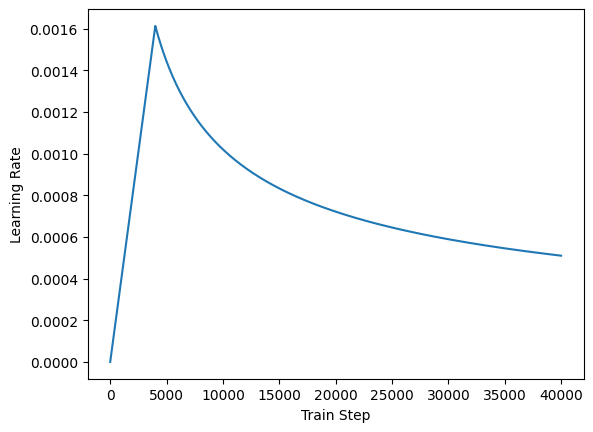

In [48]:
learning_rate = CustomSchedule(dim_model=D)

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

### make batches

In [49]:
len(inputs)

147600

In [50]:
train_len = 132800
val_len = 14784
train_inputs = inputs[:train_len]
train_outputs = outputs[:train_len]
train_outputs = tf.reshape(train_outputs,-1)
val_inputs = inputs[train_len:train_len+val_len]
val_outputs = outputs[train_len:train_len+val_len]
val_outputs = tf.reshape(val_outputs,-1)

### loss and accuracy functions

In [144]:
def loss(truths, preds):
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction='none')
  loss = loss_object(truths, preds)
  loss = tf.reduce_sum(loss)/N
  return loss

def key_accuracy(truths, preds):
  k_preds = tf.math.argmax(preds,1)
  match = truths == preds
  match = tf.cast(match, dtype=tf.int32)
  return tf.reduce_sum(match)/tf.size(match)

### compile and train

In [146]:
transformer.compile(
    loss = loss,
    optimizer = optimizer,
    metrics = [key_accuracy])

In [147]:
transformer.fit(train_inputs, train_outputs,
                epochs = 5,
                validation_data = (val_inputs, val_outputs))

Epoch 1/5
4150/4150 [==============================] - 436s 93ms/step - loss: 8.4789 - key_accuracy: 0.0000e+00 - val_loss: 8.4748 - val_key_accuracy: 0.0000e+00
Epoch 2/5
4150/4150 [==============================] - 372s 90ms/step - loss: 8.4748 - key_accuracy: 0.0000e+00 - val_loss: 8.4748 - val_key_accuracy: 0.0000e+00
Epoch 3/5
4150/4150 [==============================] - 365s 88ms/step - loss: 8.4748 - key_accuracy: 0.0000e+00 - val_loss: 8.4748 - val_key_accuracy: 0.0000e+00
Epoch 4/5
4150/4150 [==============================] - 372s 90ms/step - loss: 8.4759 - key_accuracy: 0.0000e+00 - val_loss: 8.4748 - val_key_accuracy: 0.0000e+00
Epoch 5/5
4150/4150 [==============================] - 372s 90ms/step - loss: 8.4748 - key_accuracy: 0.0000e+00 - val_loss: 8.4748 - val_key_accuracy: 0.0000e+00
